In [1]:
pip install healpy astropy

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.3/8.3 MB 15.8 MB/s eta 0:00:00


In [2]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [3]:
from astropy.io import fits
import healpy as hp
import matplotlib.pyplot as plt

file_path = '/content/gdrive/MyDrive/Krittika_CAP/K-CAP/353GHz.fits'

map = fits.open(file_path, mode='readonly')

I = map[1].data['I_STOKES']
Q = map[1].data['Q_STOKES']
U = map[1].data['U_STOKES']
I = hp.reorder(I, inp='NESTED', out='RING')
Q = hp.reorder(Q, inp='NESTED', out='RING')
U = hp.reorder(U, inp='NESTED', out='RING')

In [4]:
import matplotlib.pyplot as plt

%matplotlib inline

In [5]:
import numpy as np
import healpy as hp

**Number of pixels**

In [6]:
NPIX = len(I)
print(NPIX)
NSIDE = 2**11  #NPIX = 12*NSIDE^2
print(NSIDE)

50331648
2048


**Region of interest**

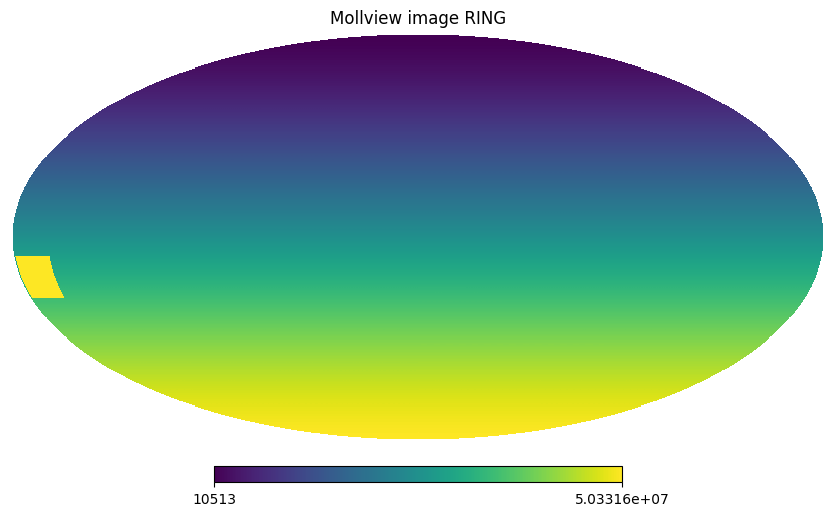

In [7]:
#Taurus: (theta, phi) = (-14.5, 172.0)
central_latitude = -14.50
central_longitude = 172.0
def deg_to_rad(angle):
  return angle*np.pi/180.0

latitude = np.radians(90.0-central_latitude)
longitude = np.radians(central_longitude)
nres = np.radians(15.0)

vertices = [hp.ang2vec(latitude - nres/2, longitude - nres/2),
    hp.ang2vec(latitude - nres/2, longitude + nres/2),
    hp.ang2vec(latitude + nres/2, longitude + nres/2),
    hp.ang2vec(latitude + nres/2, longitude - nres/2)]

ipix_poly = hp.query_polygon(nside=NSIDE, vertices=vertices)
np.savetxt('pixel_indices.csv', ipix_poly, fmt='%d', header='Pixel Indices', comments='')

m = np.arange(NPIX)
m[ipix_poly] = m.max()
hp.mollview(m, title="Mollview image RING")

In [8]:
import astropy
from astropy.io import fits

**Taurus MC (Intensity map)**

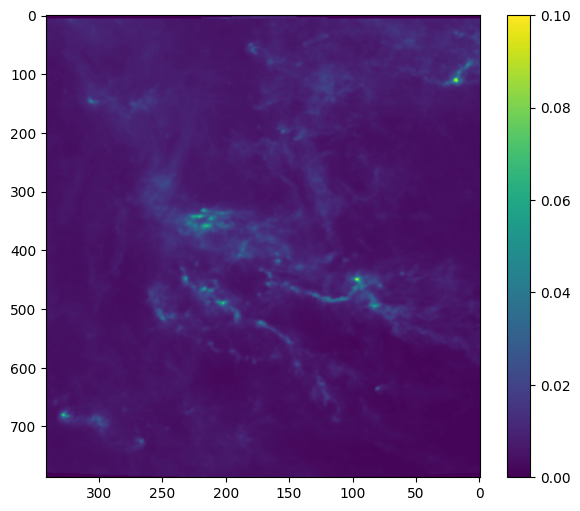

In [9]:
m = I
def display_pixels(sel_pix):
    pix_list = []
    onerow = list([sel_pix[0],])
    for i in range(1,len(sel_pix)):
        if sel_pix[i] == sel_pix[i-1] + 1:
            onerow.append(sel_pix[i])
        else:
            pix_list.append(onerow)
            onerow = [sel_pix[i],]
    sizex = np.max([len(j) for j in pix_list])
    sizey = len(pix_list)
    mat = np.zeros((sizey, sizex))
    for j in range(sizey):
        start_ind = int(sizex/2 + 1/2 ) - int( len(pix_list[j])/2 + 1/2)
        new_pix_list = pix_list[j]
        mat[j,start_ind : start_ind + len(pix_list[j])] = m[new_pix_list]
    plt.figure(figsize=(7,6))
    plt.imshow(mat, aspect='auto', vmin=0, vmax=0.1)#, cmap='coolwarm')
    plt.gca().invert_xaxis()
    #plt.contour(mat, levels = np.linspace(0,np.max(mat),5), cmap='Reds')
    #plt.title(title)
    plt.colorbar()
    plt.show()
    return mat

m = display_pixels(ipix_poly)
hdu = fits.PrimaryHDU(m)
hdu.writeto('Taurus.fits', overwrite=True)

In [10]:
import warnings
warnings.filterwarnings("ignore")

In [11]:
# from scipy.ndimage import zoom

# def resize_fits(input_file, output_file, target_size):
#     original_data = fits.getdata(input_file)
#     scale_factors = (target_size[0]/original_data.shape[0], target_size[1]/original_data.shape[1])
#     resized_data = zoom(original_data, scale_factors, order=3) #cubic interpolation for upscaling

#     header = fits.getheader(input_file)
#     header['NAXIS1'] = target_size[1]
#     header['NAXIS2'] = target_size[0]

#     fits.writeto(output_file, resized_data, header, overwrite=True)

# input_map = '/content/gdrive/MyDrive/Krittika_CAP/K-CAP/Taurus.fits'
# output_map = '/content/gdrive/MyDrive/Krittika_CAP/K-CAP/Taurus_resized.fits'
# target_size = (1200, 1200)

# resize_fits(input_map, output_map, target_size)

In [12]:
from scipy.interpolate import interp2d

input_map = '/content/gdrive/MyDrive/Krittika_CAP/K-CAP/Taurus.fits'
hdul = fits.open(input_map)
data = hdul[0].data

x = np.arange(data.shape[1])
y = np.arange(data.shape[0])

xn = np.arange(1200)
yn = np.arange(1200)

resize_fits = interp2d(x, y, data, kind='cubic', bounds_error=False)

interp_data = resize_fits(xn*len(x)/len(xn), yn*len(y)/len(yn))

header = hdul[0].header
hdu = fits.PrimaryHDU(interp_data, header=header)
hdul_interpolated = fits.HDUList([hdu])

hdul_interpolated.writeto('Taurus_resized.fits', overwrite=True)

**Resized map of Taurus**

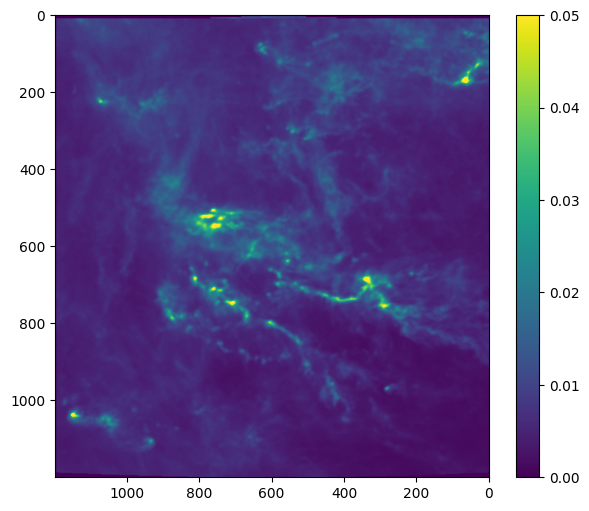

In [13]:
def display_fits_image(fits_file):
    hdulist = fits.open(fits_file)
    data = hdulist[0].data
    header = hdulist[0].header
    hdulist.close()
    plt.figure(figsize=(7,6))
    plt.imshow(data, aspect='auto', vmin=0, vmax=0.05)#, cmap='coolwarm')
    plt.gca().invert_xaxis()
    plt.colorbar()
    plt.show()

output_map = 'Taurus_resized.fits'
display_fits_image(output_map)

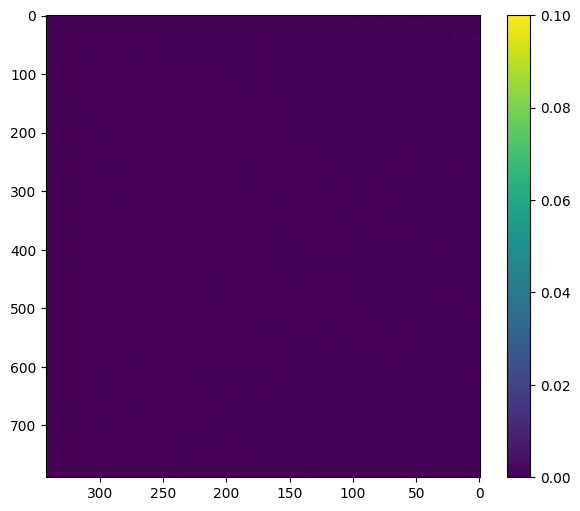

In [14]:
m = Q

if True:
  sel_pix = hp.query_polygon(nside=NSIDE, vertices=vertices, inclusive=True, nest=True)
  sel_pix = hp.nest2ring(NSIDE, sel_pix)
  sel_pix = np.sort(sel_pix)

  q = display_pixels(sel_pix)

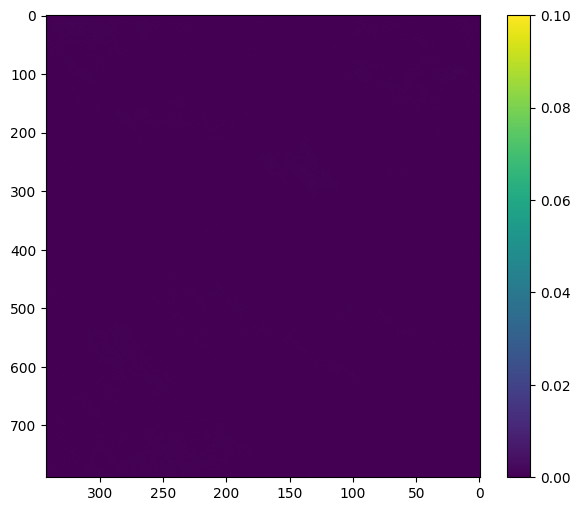

In [15]:
m = U

if True:
  sel_pix = hp.query_polygon(nside=NSIDE, vertices=vertices, inclusive=True, nest=True)
  sel_pix = hp.nest2ring(NSIDE, sel_pix)
  sel_pix = np.sort(sel_pix)

  u = display_pixels(sel_pix)

**Polarization map**

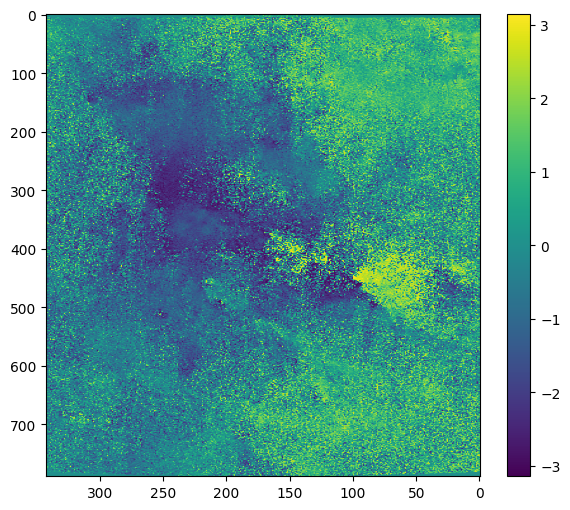

In [16]:
plt.figure(figsize=(7,6))
plt.imshow(np.arctan2(q,u), aspect='auto', vmin=-np.pi, vmax=np.pi)
plt.gca().invert_xaxis()
plt.colorbar()
plt.show()

**Resized polarization map**

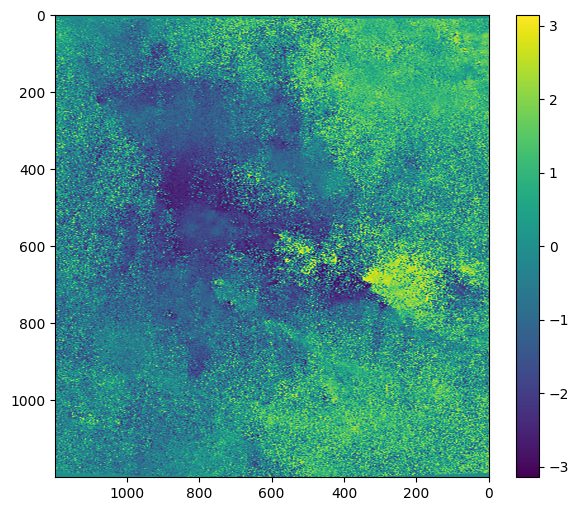

In [17]:
x = np.arange(u.shape[1])
y = np.arange(u.shape[0])

xn = np.arange(1200)
yn = np.arange(1200)

resize_image = interp2d(x, y, np.arctan2(q,u), kind='cubic', bounds_error=False)

im = resize_image(xn*len(x)/len(xn), yn*len(y)/len(yn))

header = hdul[0].header
hdu = fits.PrimaryHDU(im, header=header)
hdul_interpolated = fits.HDUList([hdu])

hdul_interpolated.writeto('polarization.fits', overwrite=True)
plt.figure(figsize=(7,6))
plt.imshow(im, aspect='auto', vmin=-np.pi, vmax=np.pi)
plt.gca().invert_xaxis()
plt.colorbar()
plt.show()

**Polarization vector map**

In [18]:
import scipy
from scipy.ndimage import gaussian_filter

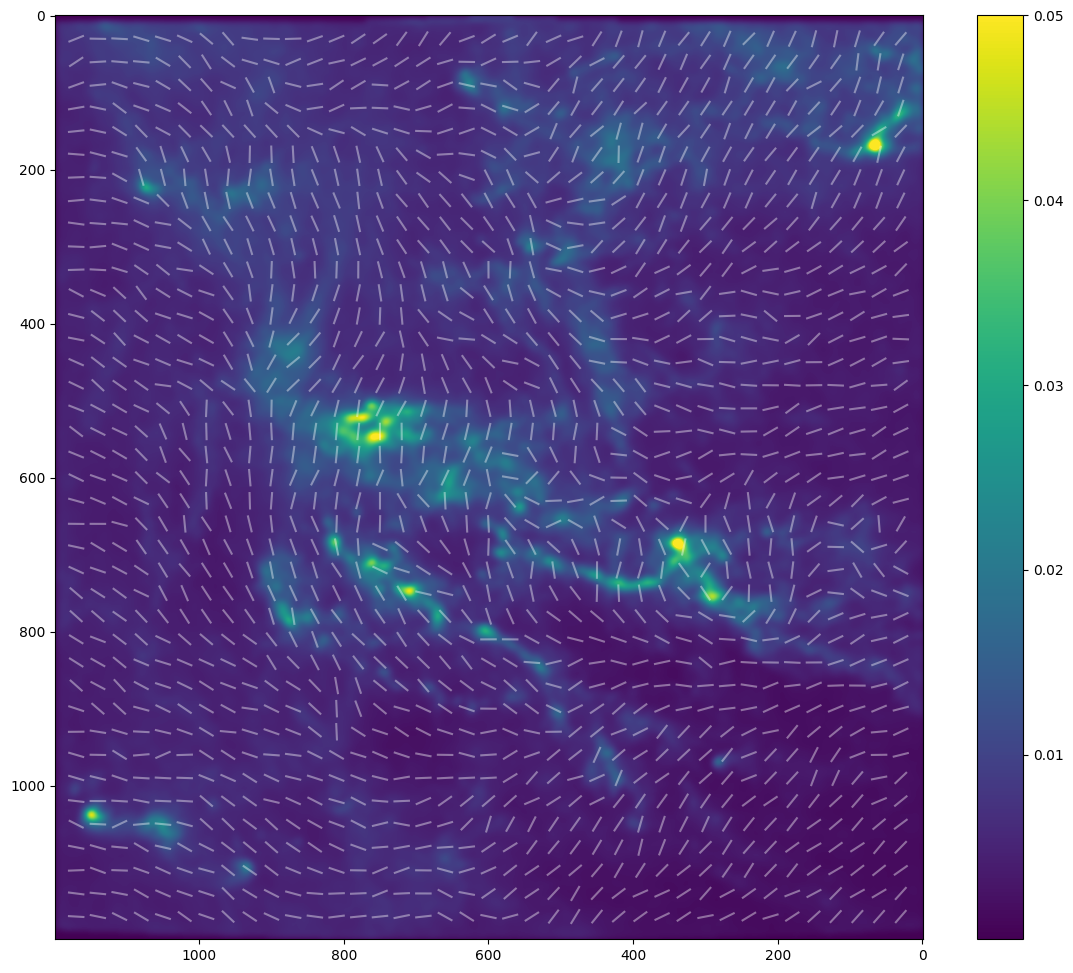

In [19]:
length = 10
step = 30
n = 2
sm = 4

#store the averaged-over-square values of the polarization angle
num_height = 1200//step
num_width = 1200//step

hdul = fits.open('polarization.fits')
polar_data = hdul[0].data

avg_polar = np.zeros((num_height, num_width))

for i in range(num_height):
  for j in range(num_width):
    square = polar_data[i*n : (i + 1)*n, j*n : (j + 1)*n]
    avg_polar_val = np.mean(square)
    avg_polar[i, j] = avg_polar_val

#plotting the polarization vector map
hdulist = fits.open('Taurus_resized.fits')
data = hdulist[0].data
header = hdulist[0].header
hdulist.close()

plt.figure(figsize=(14,12))
convolve_im = scipy.ndimage.gaussian_filter(data, [sm,sm], mode='constant')
plt.imshow(convolve_im, aspect='auto', alpha=1.0, vmax=0.05)
a = im

for i in range(step,1200,step):
  for j in range(step,1200,step):
    ang = np.mean(a[i-int(step/n):i+int(step/n), j-int(step/n):j+int(step/n)])
    x1, x2, y1, y2 = j+length*np.cos(ang), j-length*np.cos(ang), i+length*np.sin(ang), i-length*np.sin(ang)
    plt.plot([x1,x2],[y1,y2], color='white', alpha=0.4)

plt.gca().invert_xaxis()
plt.colorbar()
plt.show()

**Contour map**

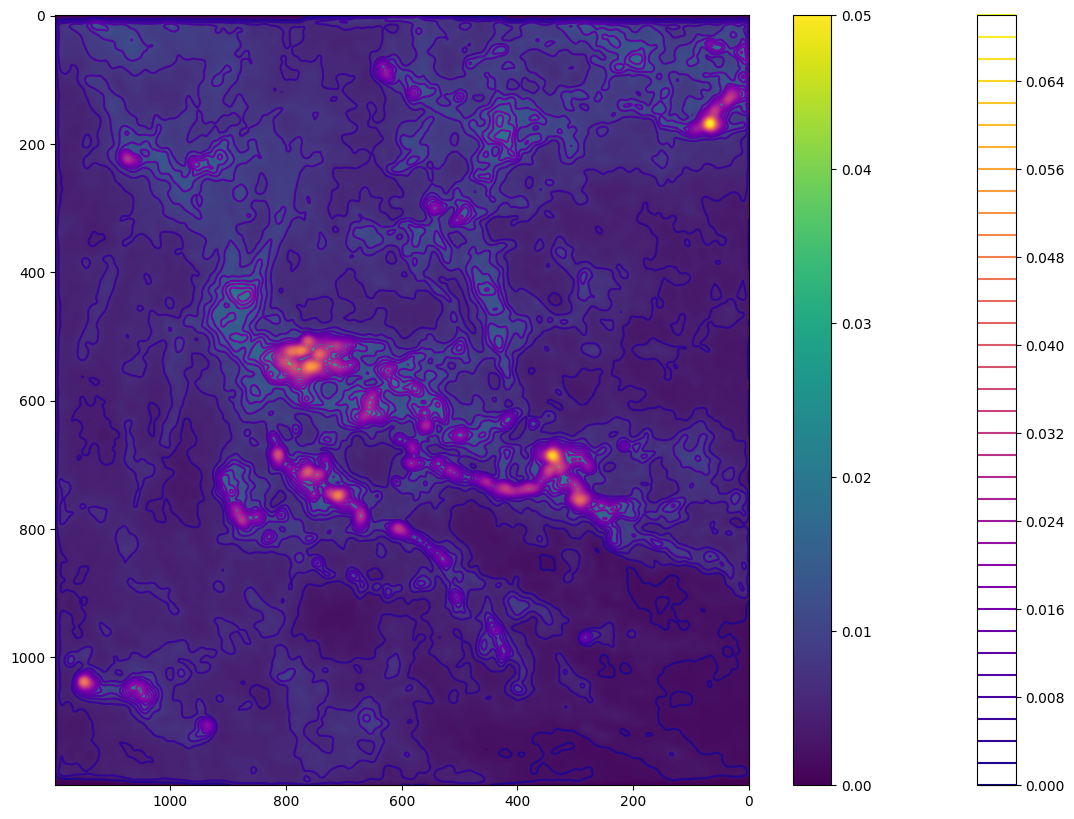

In [20]:
plt.figure(figsize=(14,10))
image = plt.imshow(convolve_im, aspect='auto', alpha=1.0, vmin=0, vmax=0.05)
contour_plot = plt.contour(convolve_im, levels=45, cmap='plasma')#colors='black')
plt.gca().invert_xaxis()
plt.colorbar(contour_plot)
plt.colorbar(image)
plt.show()

**Histogram of relative orientations**

1600


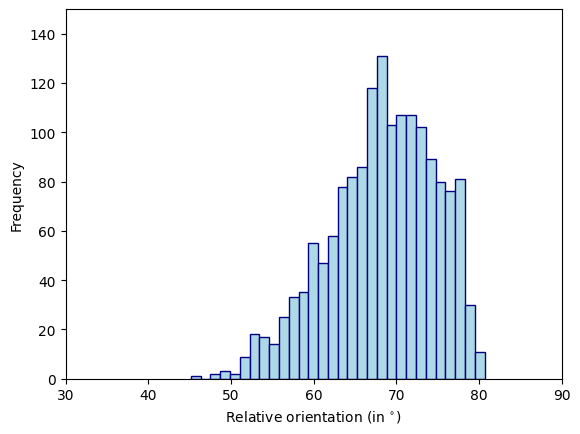

In [28]:
avg_slopes = np.zeros((num_height, num_width))

for i in range(num_height):
    for j in range(num_width):
        region = convolve_im[i*step:(i + 1)*step, j*step:(j + 1)*step]

        central_region = region[10:20, 10:20]

        contours = plt.contour(central_region, levels=20, cmap='plasma')

        slopes = []
        for collection in contours.collections:
            paths = collection.get_paths()
            for path in paths:
                x, y = path.vertices[:, 0], path.vertices[:, 1]
                slope = np.polyfit(x, y, deg=0)[0]
                slopes.append(np.arctan2(slope, 1))

        if slopes:
            avg_slope = np.mean(slopes)
            avg_slopes[i, j] = np.degrees(avg_slope)

        plt.close()

angle_diff = avg_slopes.flatten() - avg_polar.flatten()
plt.xlabel('Relative orientation (in $^{\circ}$)')
plt.ylabel('Frequency')
plt.xlim(30, 90)
plt.ylim(0, 150)
plt.hist(angle_diff, bins=30, color='lightblue', edgecolor='navy')
plt.grid(False)
print(len(avg_slopes.flatten()))

**Correlation between emission intensity and relative orientation**

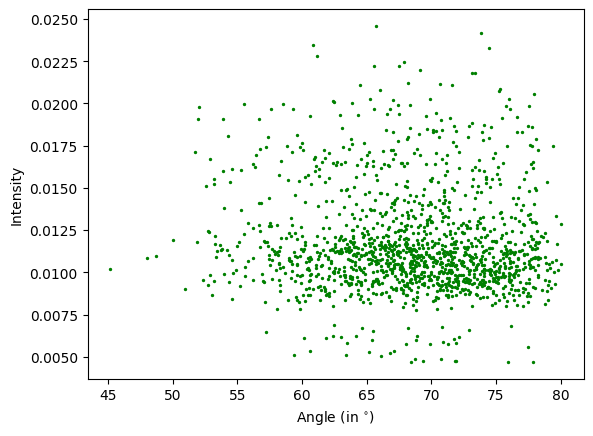

In [26]:
avg_intensity = np.zeros((num_height, num_width))

for i in range(num_height):
  for j in range(num_width):
    square = interp_data[i*n:(i + 1)*n, j*n:(j + 1)*n]
    avg_intensity_val = np.mean(square)
    avg_intensity[i, j] = avg_intensity_val

x = angle_diff
y = avg_intensity.flatten()
w = 3
midpts = np.arange(50+w/2, 90, w)
avg_y = []

mask = y>=1e-4
x = x[mask]
y = y[mask]

for midpt in midpts:
    avg_y_val = np.mean(y[(x >= midpt-w/2) & (x < midpt+w/2)])
    avg_y.append(avg_y_val)

plt.scatter(x, y, marker='o', s=2, color='green')
plt.xlabel('Angle (in $^{\circ}$)')
plt.ylabel('Intensity')
# plt.xlim(50,90)
# plt.ylim(0,0.030)
plt.show()

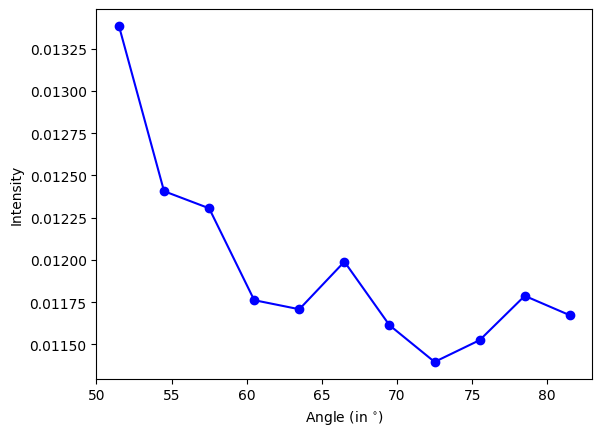

In [27]:
plt.plot(midpts, avg_y, marker='o', linestyle='-', color='blue')
plt.xlabel('Angle (in $^{\circ}$)')
plt.ylabel('Intensity')
# plt.xlim(50,90)
# plt.ylim(0.0080,0.0125)
plt.show()